## Redes sociais - APS(2)

Diogo Duarte, Pedro Dannecker e Gabriel de Araújo Alves



### Importando bibliotecas

In [1]:
import pandas as pd
import csv
from graph_tool import Graph
import os
from graph_tool import util
import netpixi
import pickle

from regression.integration.gt import *
from netpixi.integration.gt import *

### Analisando os dados iniciais e Dataframe

In [2]:
import re
import pandas as pd

df = open('wiki-RfA.txt', "r")

lines = df.readlines()
df_new=pickle.dumps(lines)
df.close()

for index, line in enumerate(lines):
       lines[index] = line.strip()

df_result = pd.DataFrame(columns=('SRC','TGT','VOT','RES','DAT','TXT'))
list_src=[]
list_tgt=[]
list_vot=[]
list_res=[]
list_dat=[]
list_txt=[]

for line in lines:
    if line.split(':')[0]=='SRC':
        list_src.append(line.split(':')[-1])
    elif line.split(':')[0]=='TGT':
        list_tgt.append(line.split(':')[-1])
    elif line.split(':')[0]=='VOT':
        list_vot.append(line.split(':')[-1])
    elif line.split(':')[0]=='RES':
        list_res.append(line.split(':')[-1])
    elif line.split(':')[0]=='DAT':
        list_dat.append(line.split(':')[-1])
    elif line.split(':')[0]=='TXT':
        list_txt.append(line.split(':')[-1])
    elif line.split(':')[0]==' ':
        pass

df_result['SRC']=list_src
df_result['TGT']=list_tgt
df_result['VOT']=list_vot
df_result['RES']=list_res
df_result['DAT']=list_dat
df_result['TXT']=list_txt

df_result.head()

,SRC,TGT,VOT,RES,DAT,TXT
0,Steel1943,BDD,1,1,"13, 19 April 2013",'''Support''' as co-nom.
1,Cuchullain,BDD,1,1,"04, 20 April 2013",'''Support''' as nominator.--
2,INeverCry,BDD,1,1,"43, 19 April 2013",'''Support''' per noms.
3,Cncmaster,BDD,1,1,"11, 20 April 2013",'''Support''' per noms. BDD is a strong contri...
4,Miniapolis,BDD,1,1,"56, 20 April 2013",GOCE|Guild of Copy Editors]] (where we're both...


#### Transformando dados faltantes em desconhecidos

In [3]:
df_result['SRC']=df_result['SRC'].replace('','Unknown')
df_result['SRC'].value_counts()

Unknown           1661
Siva1979          1232
Mailer diablo      998
Merovingian        916
Wizardman          810
                  ... 
Nunquam Dormio       1
Eastlaw              1
Yossiea              1
P.wormer             1
Nydigoveth           1
Name: SRC, Length: 10415, dtype: int64

In [4]:
list_voters=df_result['SRC'].value_counts().index

#### Retirando valores neutros da  coluna VOT

In [5]:
df_result_new=df_result[df_result.VOT!='0']


In [6]:
list_targets=df_result_new.TGT.unique()


### Criando o grafo

In [7]:
from netpixi.integration.gt import Graph

g = Graph(directed=True) # dirigido

### Criando vertices

In [8]:
for voter in list_voters:
      g.add_vertex(voter)

### Adicionando propriedades aos vértices

In [9]:
values_voters=df_result['SRC'].value_counts().values
for voter,value in zip(list_voters,values_voters):
    g.add_gp(voter)
    value=int(value)
    g[voter]=value 


### Criando arestas

In [10]:
for i in range(len(list_voters)-1):
    
    if list_voters[i]>=list_voters[i+1]:
        g.add_edge(list_voters[i],list_voters[i+1])
    else:
        g.add_edge(list_voters[i+1],list_voters[i])

### Analise exploratoria

#### a)número de vértices, número de arestas, densidade;

In [11]:
#número de vértices
n = g.num_vertices()
print('O número de vértices é {0}'.format(n))

O número de vértices é 10415


In [12]:
#número de arestas
m = g.num_edges()
print('O número de arestas é {0}'.format(m))

O número de arestas é 10414


In [13]:
##densidade
max_edges = n * (n - 1)
d = m / max_edges
print('A densidade é {0}'.format(round(d,4)))

A densidade é 0.0001


#### b)estatísticas e histograma do degree. (não é necessário in-degree e out-degree)

In [14]:
data_targets = pd.DataFrame({k: list(v) for k, v in g.vp.items()})
data_targets.head()

,id
0,Unknown
1,Siva1979
2,Mailer diablo
3,Merovingian
4,Wizardman


In [15]:
degrees = []
for v in g.all_vertices():
    degrees.append(v.total_degree())

data_targets['degree'] = degrees
data_targets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10415 entries, 0 to 10414
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      10415 non-null  object
 1   degree  10415 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 162.9+ KB


count    10415.000000
mean         1.999808
std          0.013857
min          1.000000
25%          2.000000
50%          2.000000
75%          2.000000
max          2.000000
Name: degree, dtype: float64

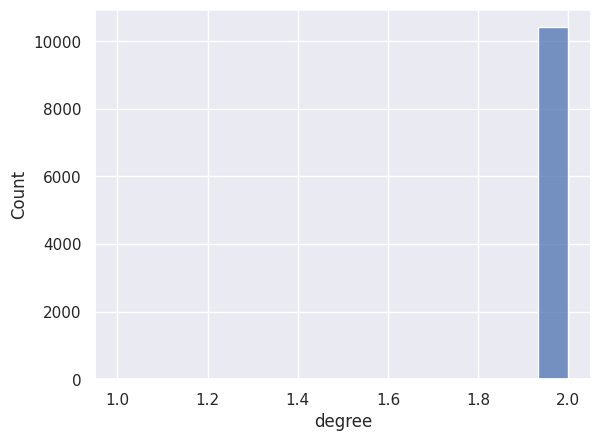

In [16]:
import seaborn as sns
sns.histplot(data_targets['degree'])
data_targets['degree'].describe()

### Análise visual do grafo:











#### salve o grafo em um arquivo;

In [18]:
gt_save(g,'Wiki-Rfa.net.gz')
g = gt_clean(g)


#### visualize o grafo a partir desse arquivo,algoritmo baseado em force-directed graph drawing;



In [19]:
g = gt_load('../notebooks/Wiki-Rfa.net.gz')
m = gt_draw.sfdp_layout(g)
gt_move(g, m)
gt_save(g, 'Wiki-Rfa.net.gz')
r=netpixi.render('Wiki-Rfa.net.gz',infinite=True);

#### ajuste as propriedades visuais do grafo

In [25]:
#códigos do tutorial A2

# mudar a cor de fundo do grafo
r.graph(color=0xffffff)

# mudar a cor e o tamanho dos vértices
r.vertex_default(color=0x000000, size=2)

# mudar a cor, a espessura e a curvatura das arestas
r.edge_default(color=0x000000, width=3, curve1=2, curve2=2)



### Cálculo centralidade beetweness

In [21]:
from graph_tool import centrality

bc, _ = centrality.betweenness(g)

### Adição para propriedade do grafo

In [22]:
g.add_vp('betweenness', bc)

In [23]:
df=gt_data(g)
df.head()

,betweenness
id,
0,0.000000e+00
1,9.221606e-09
2,0.000000e+00
3,9.221606e-09
4,0.000000e+00


In [26]:
r.vertex_set_key('id')
r.vertex_scale('betweenness', 10, 50)